In [1]:
!pip3 install influxdb-client
!pip3 install tensorflow
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install keras
# brew install libomp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.1/744.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 21.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.5 MB/s

In [2]:
!pip3 install scalecast

  Using cached SCALECAST-0.19.8-py3-none-any.whl
  Using cached tbats-1.1.3-py3-none-any.whl (44 kB)
  Using cached catboost-1.2.2-cp310-cp310-manylinux2014_x86_64.whl (98.7 MB)
  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.warnings import MissingPivotFunction
from sklearn.model_selection import train_test_split
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import time
import warnings
sns.set(rc={'figure.figsize':(25,8)})

In [62]:
# Reading data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "energy")
  |> range(start: -2y)
  |> filter(fn: (r) => r._measurement == "energy_production")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.head()

Time taken to read the data is :  19.68559718132019


,result,table,_start,_stop,_time,_measurement,region,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
0,_result,0,2022-02-03 13:28:08.390223+00:00,2024-02-04 01:28:08.390223+00:00,2022-02-03 13:30:00+00:00,energy_production,DE,1177.50,3293.75,2748.00,995.25,848.00,121.5,49.25,440.25,2558.75,268.00,1147.50,3576.25
1,_result,0,2022-02-03 13:28:08.390223+00:00,2024-02-04 01:28:08.390223+00:00,2022-02-03 13:45:00+00:00,energy_production,DE,1179.50,3293.00,2742.00,995.00,752.75,211.5,49.25,440.75,2557.50,270.50,1134.50,3535.50
2,_result,0,2022-02-03 13:28:08.390223+00:00,2024-02-04 01:28:08.390223+00:00,2022-02-03 14:00:00+00:00,energy_production,DE,1186.75,3290.75,2676.75,994.75,669.75,142.5,49.25,440.25,2555.25,270.75,1135.00,3516.00
3,_result,0,2022-02-03 13:28:08.390223+00:00,2024-02-04 01:28:08.390223+00:00,2022-02-03 14:15:00+00:00,energy_production,DE,1189.25,3290.50,2679.25,995.00,568.00,163.0,49.25,441.00,2550.00,272.50,1150.50,3468.50
4,_result,0,2022-02-03 13:28:08.390223+00:00,2024-02-04 01:28:08.390223+00:00,2022-02-03 14:30:00+00:00,energy_production,DE,1188.50,3296.75,2714.25,994.50,461.50,243.0,49.25,440.00,2550.25,281.50,1186.25,3422.75


In [63]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'region']
df = df.drop(columns=columns_to_drop, inplace=False)

# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

# Sort the DataFrame by index
df = df.sort_index()

df_Photovoltaik = df[["Photovoltaik"]]

print(df_Photovoltaik)
nan_count = df_Photovoltaik.isna().sum()
print("df_Photovoltaik shape is : ", df_Photovoltaik.shape)
print("Number of NaN values in 'Photovoltaik' column:", nan_count)
df_Photovoltaik = df_Photovoltaik.ffill() # forward filling missing values
#df_Photovoltaik = df_Photovoltaik.dropna()
print("df_Photovoltaik shape is : ", df_Photovoltaik.shape)

                           Photovoltaik
_time                                  
2022-02-03 13:30:00+00:00        848.00
2022-02-03 13:45:00+00:00        752.75
2022-02-03 14:00:00+00:00        669.75
2022-02-03 14:15:00+00:00        568.00
2022-02-03 14:30:00+00:00        461.50
...                                 ...
2024-02-03 23:15:00+00:00           NaN
2024-02-03 23:30:00+00:00           NaN
2024-02-03 23:45:00+00:00           NaN
2024-02-04 00:00:00+00:00           NaN
2024-02-04 00:15:00+00:00           NaN

[70092 rows x 1 columns]
df_Photovoltaik shape is :  (70092, 1)
Number of NaN values in 'Photovoltaik' column: Photovoltaik    282
dtype: int64
df_Photovoltaik shape is :  (70092, 1)


In [64]:
df_Photovoltaik.head()

,Photovoltaik
_time,
2022-02-03 13:30:00+00:00,848.00
2022-02-03 13:45:00+00:00,752.75
2022-02-03 14:00:00+00:00,669.75
2022-02-03 14:15:00+00:00,568.00
2022-02-03 14:30:00+00:00,461.50


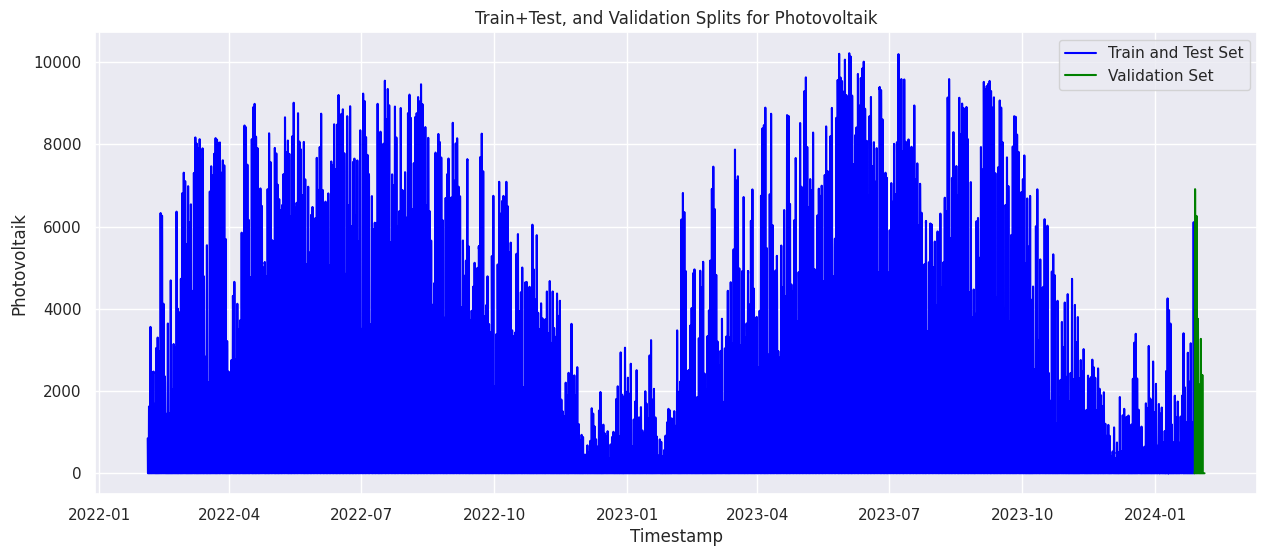

In [65]:
# Train, Test and Validation Splits
train_test_data = df_Photovoltaik[:-672].copy()

# Split data into train, test, and validation sets
validation_data = df_Photovoltaik[-672:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(train_test_data.index, train_test_data['Photovoltaik'], label='Train and Test Set', color='blue')
plt.plot(validation_data.index, validation_data['Photovoltaik'], label='Validation Set', color='green')

plt.title('Train+Test, and Validation Splits for Photovoltaik')
plt.xlabel('Timestamp')
plt.ylabel('Photovoltaik')
plt.legend()
plt.show()

In [66]:
f = Forecaster(y=train_test_data.Photovoltaik,current_dates=train_test_data.index, freq='15min')

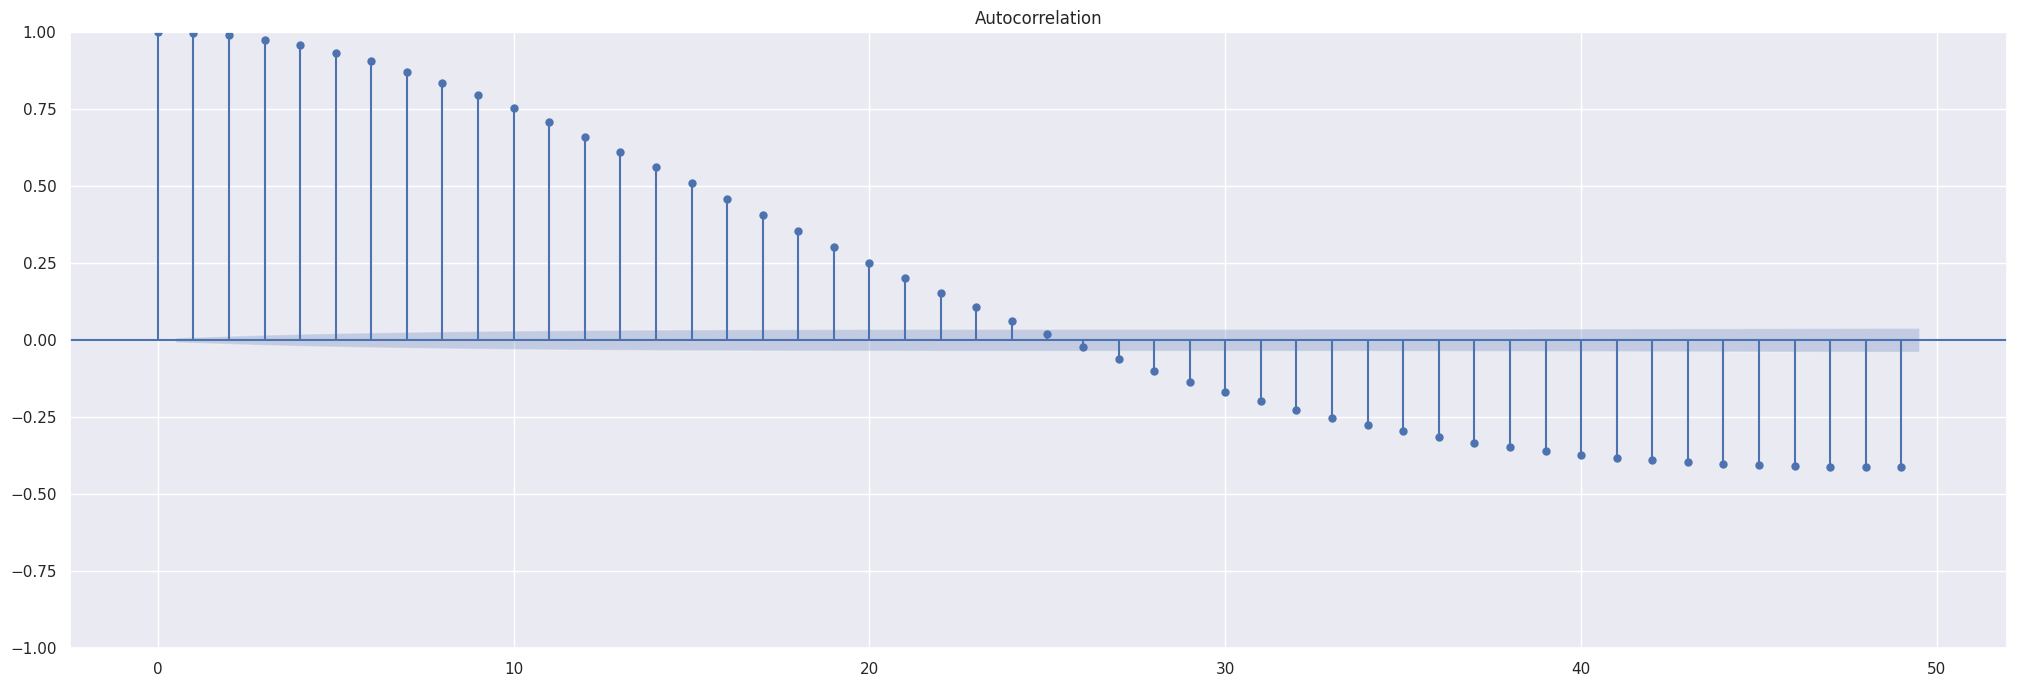

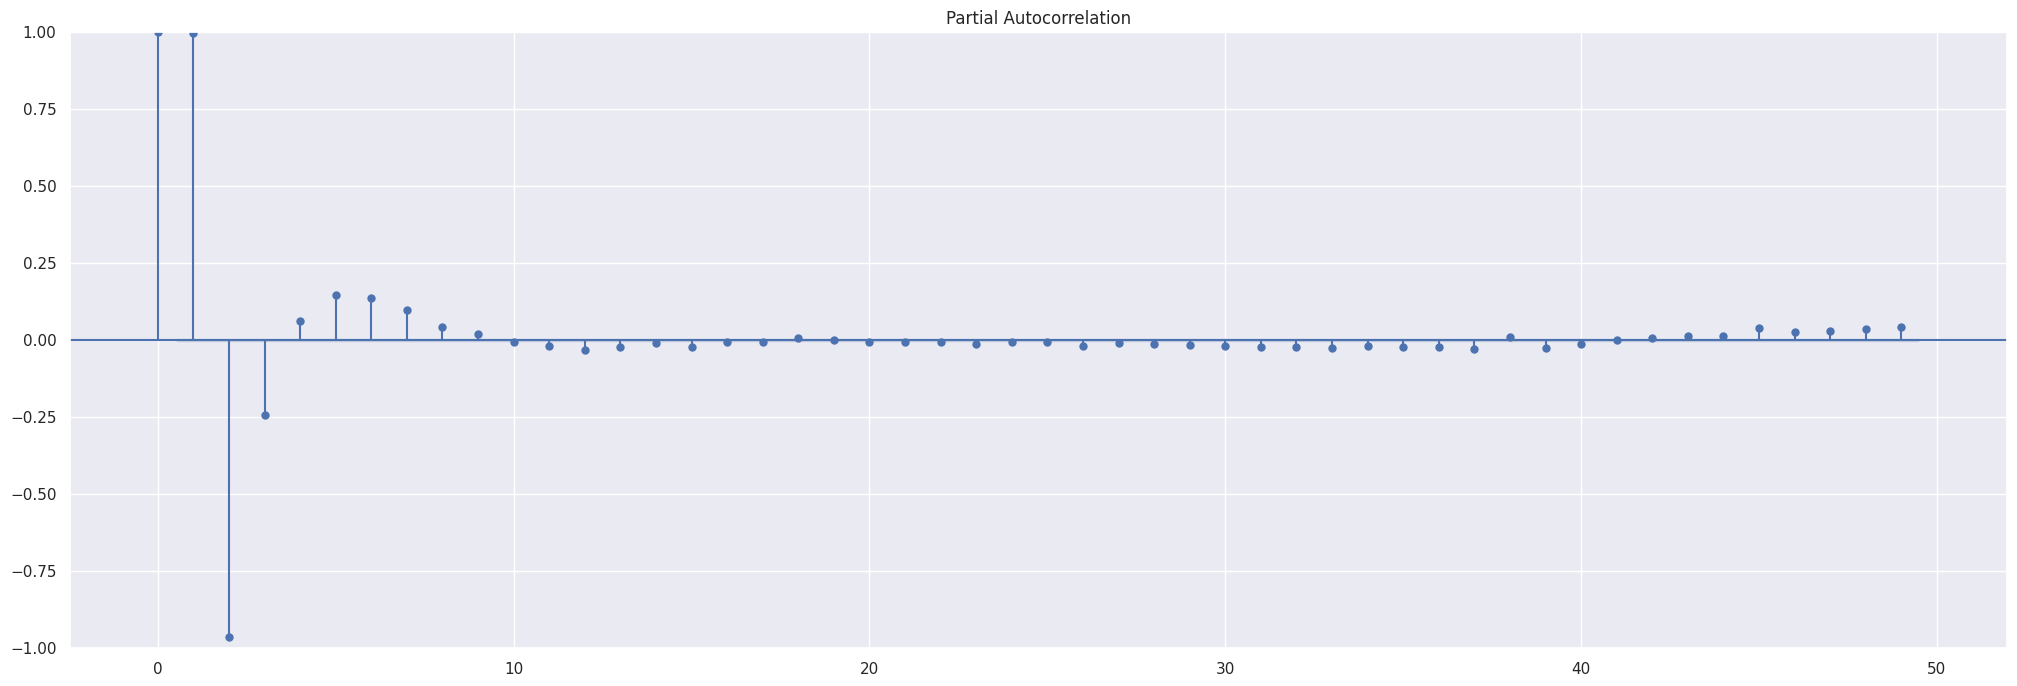

In [67]:
f.plot_acf()
f.plot_pacf()
plt.show()

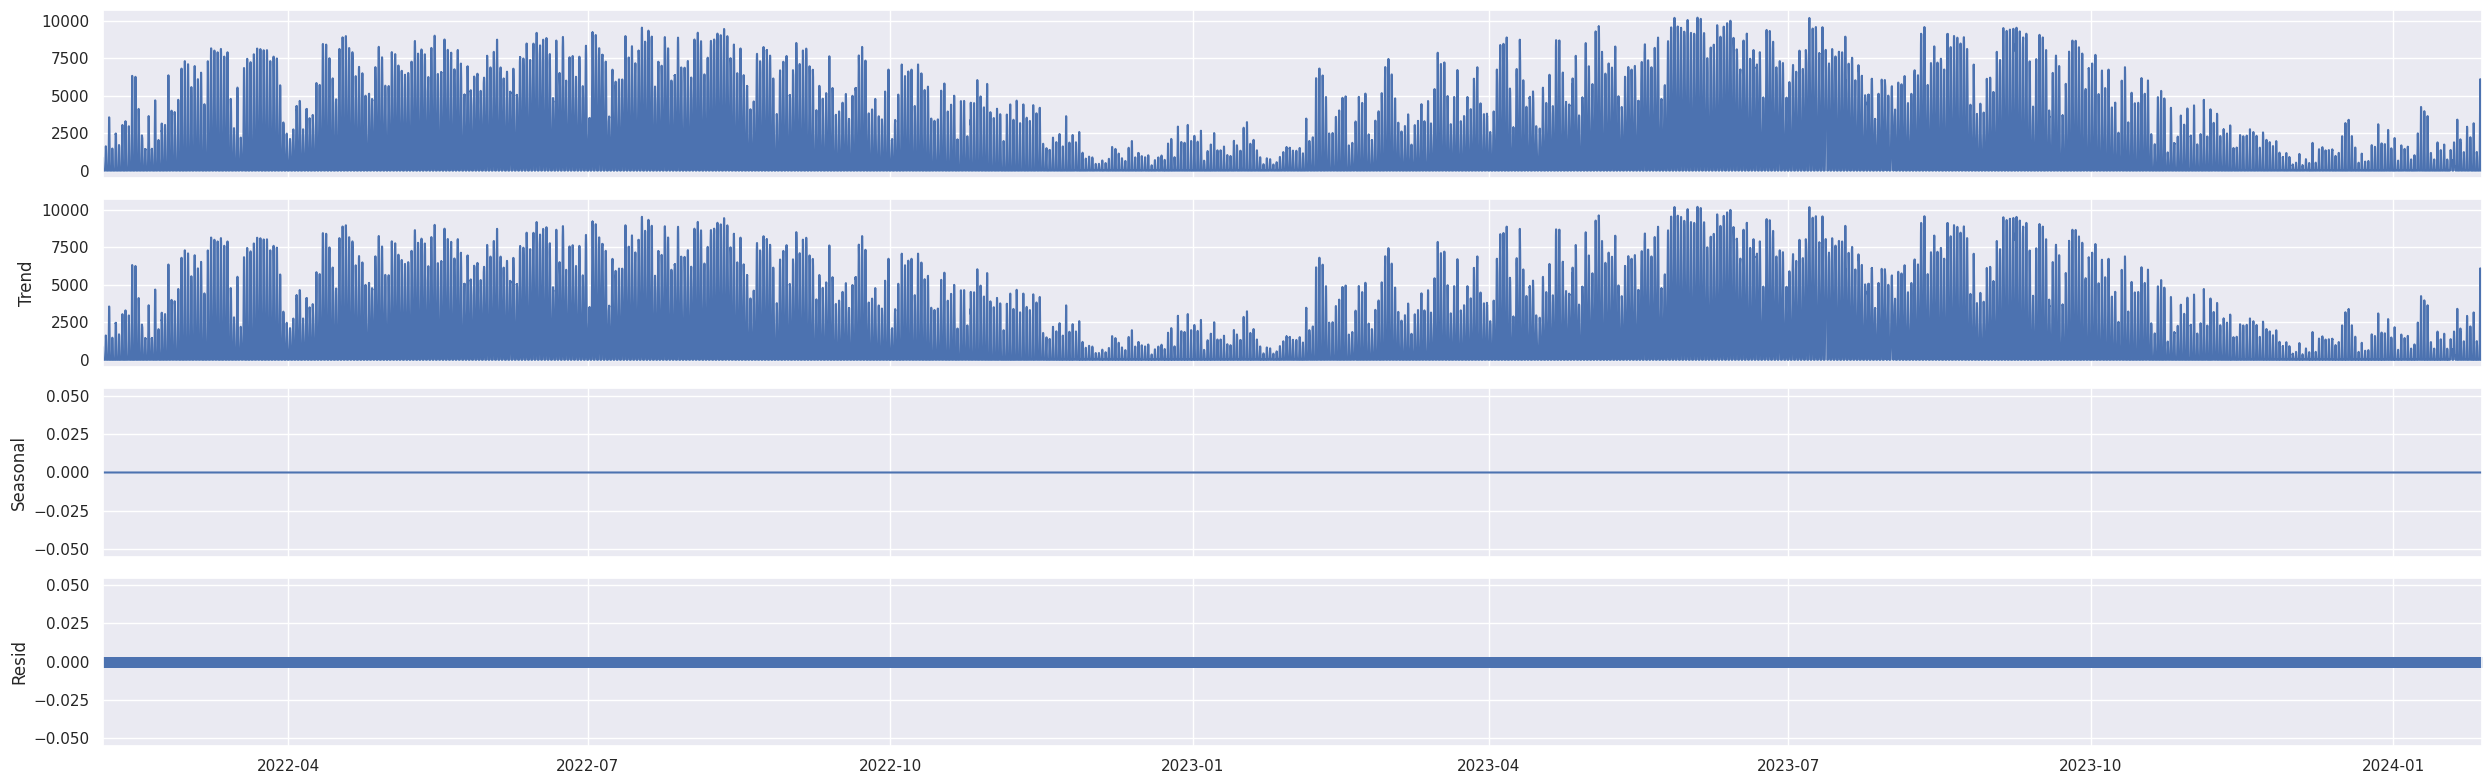

In [68]:
# Perform seasonal decomposition
result = seasonal_decompose(train_test_data, model='additive', extrapolate_trend='freq', period=1)

# Plot the decomposed components
result.plot()
plt.show()

In [69]:
is_stationary = f.adf_test(full_res=False)
print(is_stationary)

True


In [70]:
f.set_test_length(0.10)

In [71]:
f.eval_cis()

In [72]:
f.add_time_trend()

In [73]:
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

In [74]:
f.generate_future_dates(1344)
f.set_estimator('lstm')

Epoch 1/25
1561/1561 [==============================] - 23s 11ms/step - loss: 0.1010 - val_loss: 0.1766
Epoch 2/25
1561/1561 [==============================] - 15s 10ms/step - loss: 0.0871 - val_loss: 0.1785
Epoch 3/25
1561/1561 [==============================] - 15s 10ms/step - loss: 0.0837 - val_loss: 0.1820
Epoch 4/25
1561/1561 [==============================] - 16s 10ms/step - loss: 0.0818 - val_loss: 0.1815
Epoch 5/25
1561/1561 [==============================] - 15s 10ms/step - loss: 0.0807 - val_loss: 0.1847
Epoch 6/25
1561/1561 [==============================] - 15s 10ms/step - loss: 0.0797 - val_loss: 0.1794
Epoch 7/25
1561/1561 [==============================] - 15s 10ms/step - loss: 0.0791 - val_loss: 0.1833
Epoch 8/25
1561/1561 [==============================] - 15s 10ms/step - loss: 0.0783 - val_loss: 0.1815
Epoch 9/25
1/1 [==============================] - 1s 1s/step


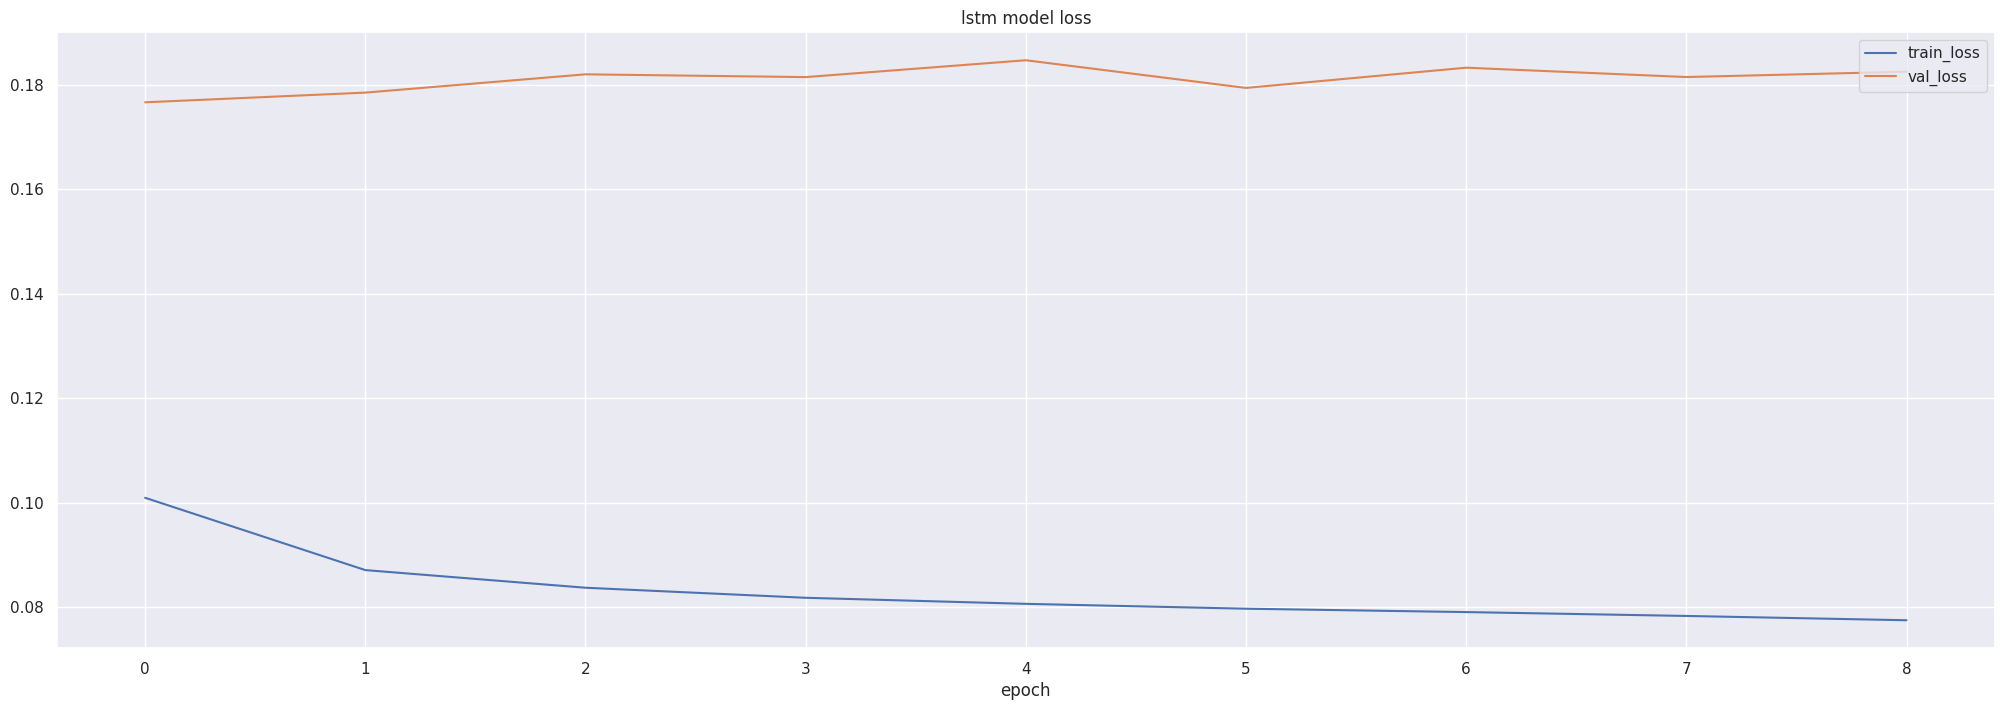

Epoch 1/25
1914/1914 [==============================] - 24s 10ms/step - loss: 0.0836 - val_loss: 0.0675
Epoch 2/25
1914/1914 [==============================] - 19s 10ms/step - loss: 0.0677 - val_loss: 0.0512
Epoch 3/25
1914/1914 [==============================] - 18s 10ms/step - loss: 0.0636 - val_loss: 0.0500
Epoch 4/25
1914/1914 [==============================] - 19s 10ms/step - loss: 0.0620 - val_loss: 0.0593
Epoch 5/25
1914/1914 [==============================] - 18s 10ms/step - loss: 0.0604 - val_loss: 0.0490
Epoch 6/25
1914/1914 [==============================] - 19s 10ms/step - loss: 0.0593 - val_loss: 0.0420
Epoch 7/25
1914/1914 [==============================] - 18s 9ms/step - loss: 0.0587 - val_loss: 0.0385
Epoch 8/25
1914/1914 [==============================] - 18s 10ms/step - loss: 0.0582 - val_loss: 0.0460
Epoch 9/25
1914/1914 [==============================] - 19s 10ms/step - loss: 0.0575 - val_loss: 0.0457
Epoch 10/25
1914/1914 [==============================] - 18s 9ms/

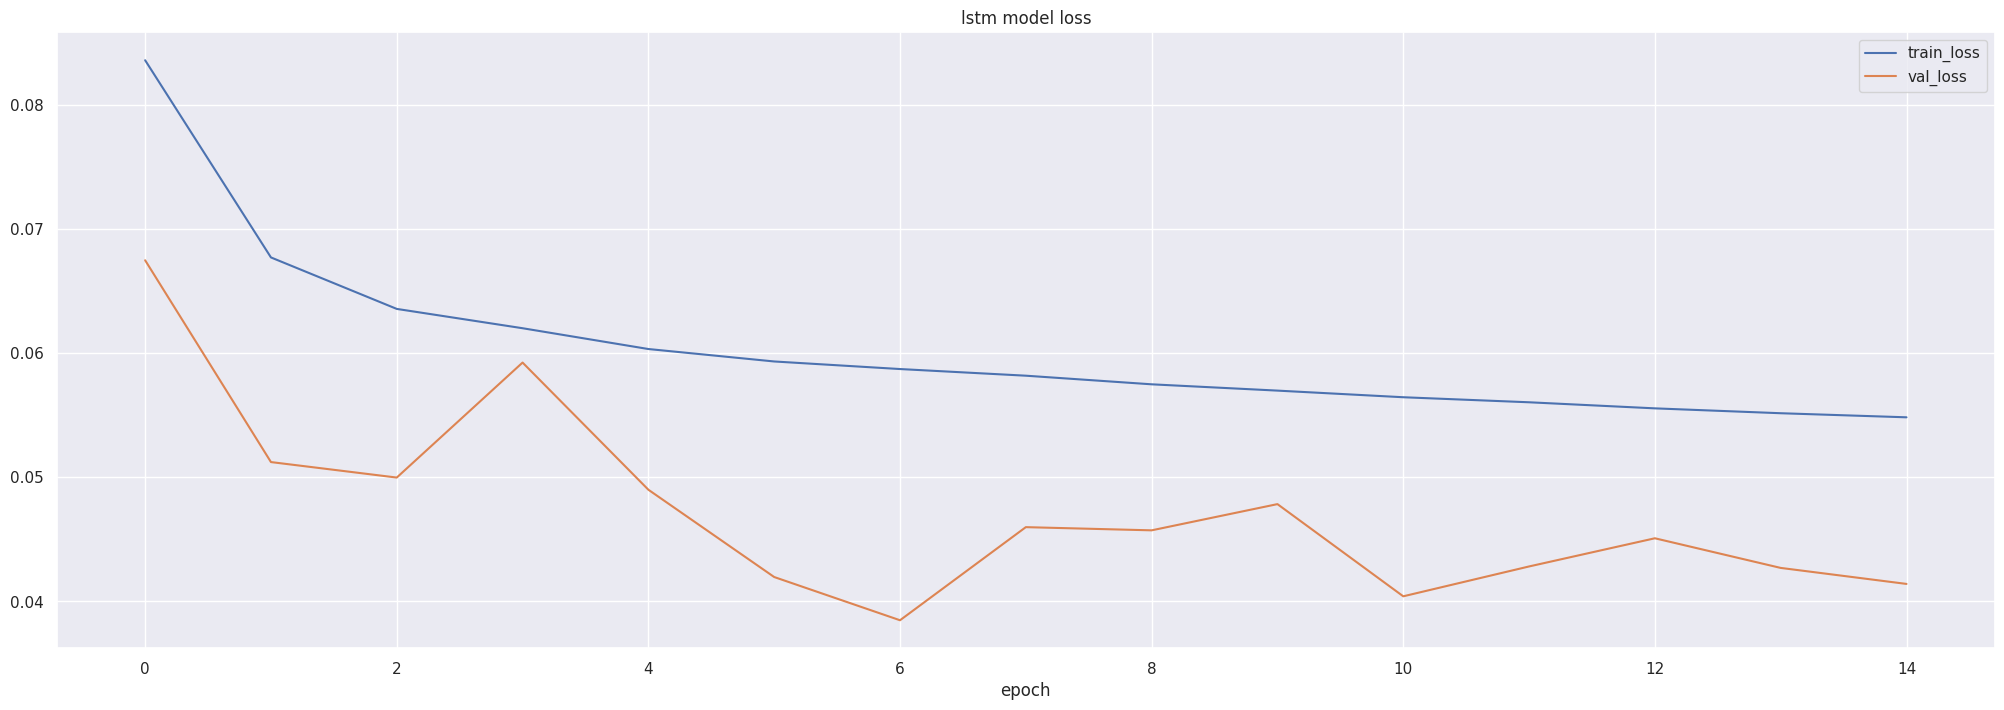

In [75]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=25,
                  validation_split=0.1,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

There are no NaN values in the 'Photovoltaik' column.
Mean Absolute Percentage Error (MAPE) validation set vs prediction set : 73300440573600448512.00%
Mean Absolute Error (MAE) validation set vs prediction set : 505.27963766801156
Root Mean Squared Error (RMSE) validation set vs prediction set : 949.1245200012937


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


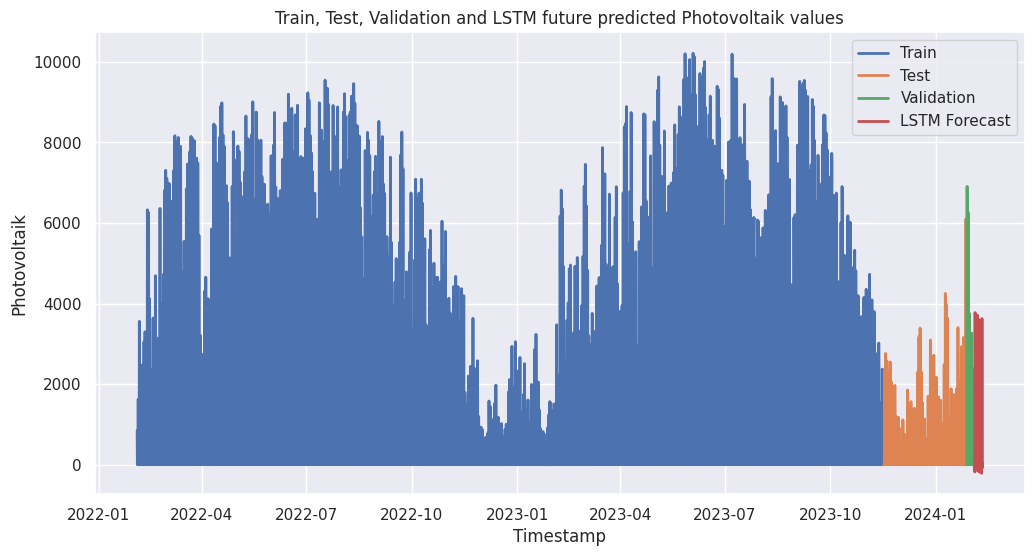

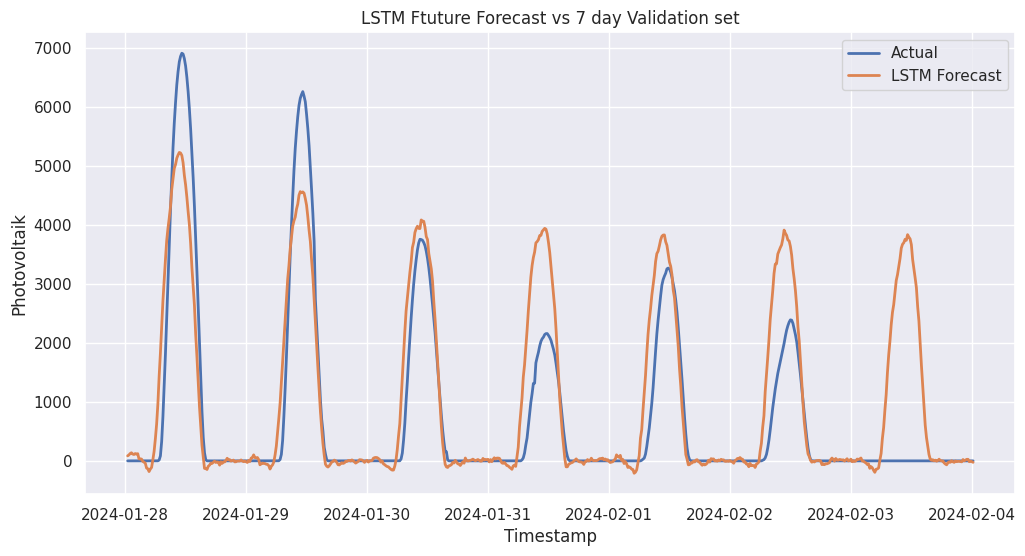

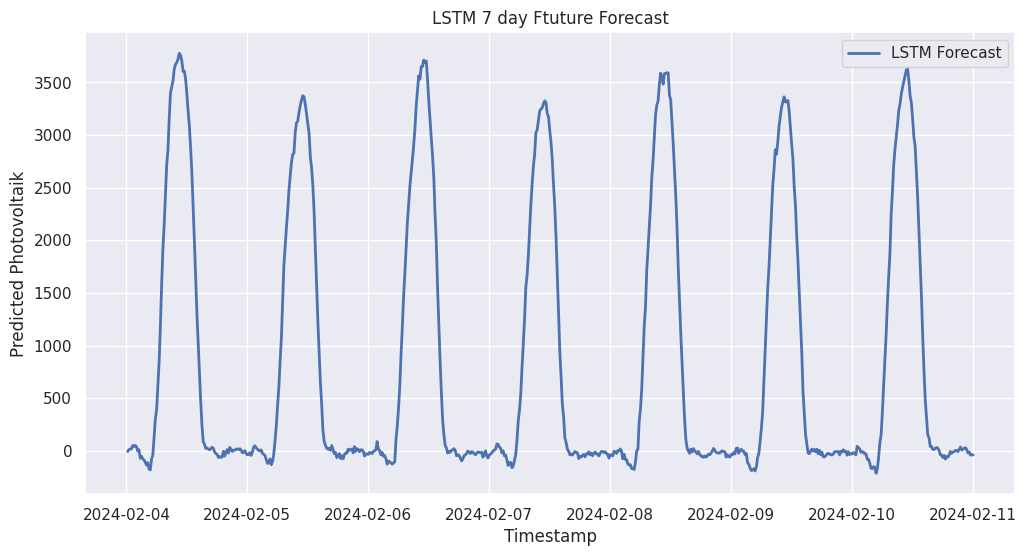

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Get fture forecast values and index
lstm_default_forecasted_df = f.export('lvl_fcsts')
last_timestamp = validation_data.index[-1]
new_index = pd.date_range(start=last_timestamp, periods=672, freq='15T')
existing_index_series = pd.Series(validation_data.index)
new_index_series = pd.Series(new_index)
concatenated_series = pd.concat([existing_index_series, new_index_series])
lstm_default_forecasted_df.index = concatenated_series

nan_check = validation_data["Photovoltaik"].isna().any()
# or nan_check = validation_data["Photovoltaik"].isnull().any()

if nan_check:
    print("There are NaN values in the 'Photovoltaik' column.")
else:
    print("There are no NaN values in the 'Photovoltaik' column.")

# Calculate Metrics
mae = mean_absolute_error(validation_data["Photovoltaik"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
mape = mean_absolute_percentage_error(validation_data["Photovoltaik"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
rmse = mean_squared_error(validation_data["Photovoltaik"].values, lstm_default_forecasted_df["lstm_best"].values[:672], squared=False)

# Print metrics
print(f'Mean Absolute Percentage Error (MAPE) validation set vs prediction set : {mape*100:.2f}%')
print(f'Mean Absolute Error (MAE) validation set vs prediction set : {mae}')
print(f'Root Mean Squared Error (RMSE) validation set vs prediction set : {rmse}')

# Split train_test_data into separate train and test sets and train_index and test_index
train_index, test_index = train_test_split(train_test_data.index, test_size=0.1, shuffle=False, random_state=42)
train,test = train_test_split(train_test_data["Photovoltaik"], test_size=0.1, shuffle=False, random_state=42)


# Plotting train+test, validation and future predictions together
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Train', linewidth=2)
plt.plot(test_index, test, label='Test', linewidth=2)
plt.plot(validation_data.index, validation_data["Photovoltaik"], label='Validation', linewidth=2)
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Photovoltaik')
plt.title('Train, Test, Validation and LSTM future predicted Photovoltaik values')
plt.legend()
plt.show()

# Plotting simulated future with validation
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data["Photovoltaik"], label='Actual', linewidth=2)
plt.plot(validation_data.index, lstm_default_forecasted_df["lstm_best"][:672], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Photovoltaik')
plt.title('LSTM Ftuture Forecast vs 7 day Validation set')
plt.legend()
plt.show()

# Plotting real future
plt.figure(figsize=(12, 6))
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Predicted Photovoltaik')
plt.title('LSTM 7 day Ftuture Forecast')
plt.legend()
plt.show()


In [77]:
last_672_rows = lstm_default_forecasted_df.tail(672)
result_df = pd.DataFrame({
    'Timestamp': last_672_rows.index,
    'Predicted_Photovoltaik_Values': last_672_rows["lstm_best"].values
})

# Save the last 672 rows to a CSV file
last_672_rows.to_csv("Photovoltaik_7_Days_Future_Forecast.csv", index=False)

In [78]:
first_672_rows = lstm_default_forecasted_df.tail(672)
result_df = pd.DataFrame({
    'Timestamp': validation_data.index,
    'Actual_Photovoltaik_Values': validation_data["Photovoltaik"].values,
    'Predicted_Photovoltaik_Values': first_672_rows["lstm_best"].values
})

# Save the DataFrame to a CSV file
result_df.to_csv("Photovoltaik_7_Days_Prediction_Validation_Data.csv", index=False)